In [11]:
# Begin by importing all required libraries
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
from sklearn import datasets
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import xgboost as xgb
# import lightgbm as lgb
from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_val_score
from catboost import CatBoostClassifier

import warnings
warnings.filterwarnings('ignore')

# Prepare Data for Training

Before any preprocessing, it's important to understand the structure, type, and quality of the raw data. This involves looking at the first few rows, which can give insights into the various features available and their data types.

Decision tree algorithms can't handle missing values directly. The presence of missing data can lead to errors during the fit process or can significantly bias the model. Calculating the percentage of missing data helps in making informed decisions about whether to impute missing values, drop the rows/columns, or use techniques like introducing a 'missing' category for categorical data.

Replacing missing values with a central tendency measure (median for numerical data and mode for categorical data) is a common practice to retain valuable data points. It's preferable to dropping rows or columns entirely, especially in datasets where data is scarce. Dropping unnecessary columns like 'PassengerId', 'Name', and 'VIP' is done to remove features that are unlikely to be useful for the model. These might include identifiers that are unique to each instance or features that don't contribute to the predictive power of the model.

Transforming 'Cabin' into 'Deck' and 'Side' is an example of feature engineering, where new features are created from existing ones. This can help the decision tree capture more nuanced patterns in the data that might not be apparent from the original features.Decision trees require all data to be numerical. Converting boolean values to integers (e.g., 'CryoSleep') and applying label encoding to categorical variables transforms them into a format that the algorithm can work with. Label encoding assigns a unique integer to each category of a feature, making the data suitable for modeling without introducing an arbitrary ordinal relationship.

In [9]:
# Read data
train_df = pd.read_csv('csv_files/train.csv')

# Preview data
print('Raw data format:')
display(train_df.head())

# Determining the amount of missing data per column
missing_data = train_df.isna().sum()

# Calculating the percentage of missing data per column
missing_percentage = (missing_data / len(train_df)) * 100

missing_info = pd.DataFrame({
    "Missing Values": missing_data,
    "Percentage": missing_percentage
})

missing_info.sort_values(by="Missing Values", ascending=False)

# Imputers
median_imputer = SimpleImputer(strategy='median')
mode_imputer = SimpleImputer(strategy='most_frequent')

# List of numerical and categorical columns that need imputation
numerical_cols = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
categorical_cols = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP']

# Imputation
train_df[numerical_cols] = median_imputer.fit_transform(train_df[numerical_cols])
train_df[categorical_cols] = mode_imputer.fit_transform(train_df[categorical_cols])


# Assuming train_df is predefined
decision_tree_df = train_df.copy()  # Use copy to avoid SettingWithCopyWarning

# Drop unnecessary columns
decision_tree_df.drop(columns=['PassengerId', 'Name', 'VIP'], inplace=True)

decision_tree_df.dropna(subset=['Cabin'], inplace=True)

# Split 'Cabin' into 'Deck' and 'Side'
decision_tree_df['Deck'] = decision_tree_df['Cabin'].str.split('/').str[0]
decision_tree_df['Side'] = decision_tree_df['Cabin'].str.split('/').str[2]

decision_tree_df.drop(columns=['Cabin'], inplace=True) 

# Convert 'CryoSleep' boolean to int
decision_tree_df['CryoSleep'] = decision_tree_df['CryoSleep'].astype(int)

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Encode categorical variables
for col in ['HomePlanet', 'Destination', 'Deck', 'Side']:
    decision_tree_df[col] = label_encoder.fit_transform(decision_tree_df[col])

# After edits for decision trees
print('DataFrame used for trees:')
decision_tree_df.head()


Raw data format:


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


DataFrame used for trees:


,HomePlanet,CryoSleep,Destination,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Deck,Side
0,1,0,2,39.0,0.0,0.0,0.0,0.0,0.0,False,1,0
1,0,0,2,24.0,109.0,9.0,25.0,549.0,44.0,True,5,1
2,1,0,2,58.0,43.0,3576.0,0.0,6715.0,49.0,False,0,1
3,1,0,2,33.0,0.0,1283.0,371.0,3329.0,193.0,False,0,1
4,0,0,2,16.0,303.0,70.0,151.0,565.0,2.0,True,5,1


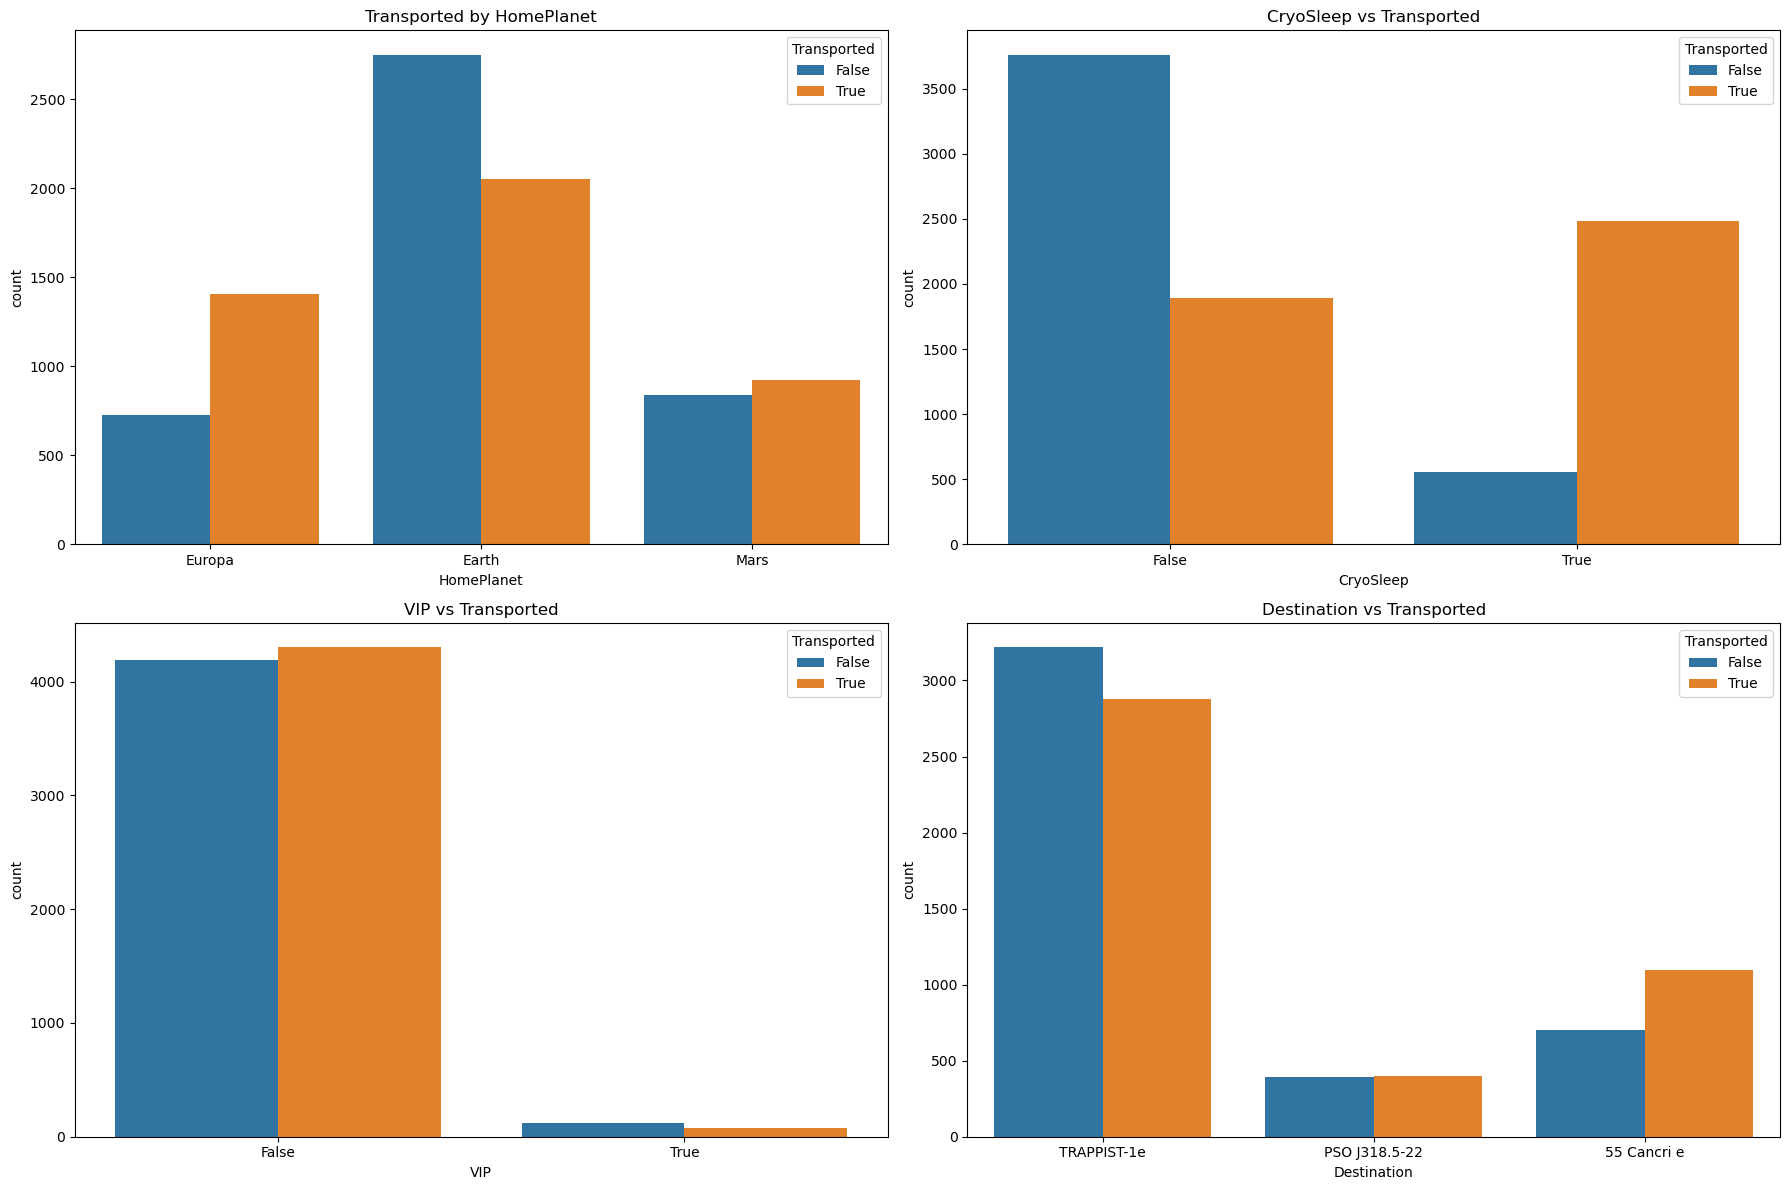

In [10]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18, 12)) 

sns.countplot(x='HomePlanet', hue='Transported', data=train_df, ax=axes[0, 0])
axes[0, 0].set_title('Transported by HomePlanet')

sns.countplot(x='CryoSleep', hue='Transported', data=train_df, ax=axes[0, 1])
axes[0, 1].set_title('CryoSleep vs Transported')

sns.countplot(x='VIP', hue='Transported', data=train_df, ax=axes[1, 0])
axes[1, 0].set_title('VIP vs Transported')

sns.countplot(x='Destination', hue='Transported', data=train_df, ax=axes[1, 1])
axes[1, 1].set_title('Destination vs Transported')

plt.tight_layout() 
plt.show()


In [14]:
# Remove the categorical columns
features_df = train_df.drop(columns=['HomePlanet', 'CryoSleep', 'VIP', 'Destination', 'Transported'])

# Separate the target variable
target = train_df['Transported']

display(features_df)

,PassengerId,Cabin,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0001_01,B/0/P,39.0,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy
1,0002_01,F/0/S,24.0,109.0,9.0,25.0,549.0,44.0,Juanna Vines
2,0003_01,A/0/S,58.0,43.0,3576.0,0.0,6715.0,49.0,Altark Susent
3,0003_02,A/0/S,33.0,0.0,1283.0,371.0,3329.0,193.0,Solam Susent
4,0004_01,F/1/S,16.0,303.0,70.0,151.0,565.0,2.0,Willy Santantines
...,...,...,...,...,...,...,...,...,...
8688,9276_01,A/98/P,41.0,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther
8689,9278_01,G/1499/S,18.0,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley
8690,9279_01,G/1500/S,26.0,0.0,0.0,1872.0,1.0,0.0,Fayey Connon
8691,9280_01,E/608/S,32.0,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre


In [20]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Load your data
# Assuming 'preprocess_data' is a function you have defined to preprocess your data
train_df = preprocess_data('csv_files/train.csv', is_train=True)
test_df = preprocess_data('csv_files/test.csv', is_train=False)

# Prepare features and target
features = [col for col in train_df.columns if col not in ['PassengerId', 'Name', 'Transported', 'Cabin_Deck', 'HomePlanet_TotalSpending', 'Destination_TotalSpending']]
X = train_df[features]
y = train_df['Transported']

# Splitting the dataset
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Handling class imbalance with SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Initialize XGBoost classifier
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Define hyperparameter grid for tuning
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1],
}

# Setup GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='accuracy', cv=3, verbose=1)

# Perform grid search
grid_search.fit(X_train_smote, y_train_smote)

# Best model after grid search
best_xgb_model = grid_search.best_estimator_

# Make predictions on the validation set
predictions = best_xgb_model.predict(X_val)

# Evaluate the best model
accuracy = accuracy_score(y_val, predictions)
print(f'Best Model Accuracy: {accuracy}')

# You can access the best parameters like this
best_params = grid_search.best_params_
print(f'Best Parameters: {best_params}')


ValueError: could not convert string to float: 'Earth'

# 1. Decision Trees

### Decision Trees in Machine Learning

A Decision Tree is a non-parametric supervised learning method used for classification and regression tasks. It creates a model that predicts the target variable by learning decision rules from features.

#### Structure of a Decision Tree

- **Nodes**: These define the structure of a decision tree.
  - **Root Node**: Represents the entire dataset and is the starting point of the tree.
  - **Decision Nodes**: Nodes that split into more nodes based on a decision rule.
  - **Leaf Nodes/Terminal Nodes**: Nodes that provide the prediction and do not split further.

#### Learning Process

1. **Select the Best Feature**: The algorithm selects the feature that results in the most beneficial split according to a certain criterion (e.g., Gini impurity, entropy, or variance reduction).

2. **Split the Data**: The dataset is divided into subsets based on the selected feature.

3. **Recurse on Each Sub-Dataset**: The splitting process is applied recursively to each subset.

4. **Stopping Criteria**: The recursion stops if any of the following conditions are met:
   - All observations in a node have the same value of the target variable.
   - No further features are available to split on.
   - A predefined tree depth is reached.
   - A node has too few samples to split further.

5. **Prediction**: To make a prediction:
   - **Classification**: Traverse from the root to a leaf node based on the input features, and use the class label of the leaf as the prediction.
   - **Regression**: Similarly, traverse the tree, but the prediction is a continuous value, typically the average of target values in the leaf node.

#### Important Features of Decision Trees

- **Interpretability**: Easy to understand and interpret visually.
- **Non-Linear Data Handling**: Can process both numerical and categorical data and model complex relationships.
- **Feature Importance**: They prioritize the most informative features first.
- **Overfitting**: Prone to overfitting, which can be mitigated by pruning, setting maximum depth, or minimum samples per leaf.


# Types of Decision Trees and Tree-Based Models

Decision trees and tree-based models are powerful tools in machine learning for handling both regression and classification tasks. They involve segmenting the predictor space into a number of simple regions to make predictions. Here, we discuss the traditional Decision Tree and its advanced ensemble variants like Gradient Boost, Extreme Gradient Boost (XGBoost), LightGBM, and CatBoost.

## 1. Decision Tree

A Decision Tree is a non-linear predictive model that recursively splits data into branches, making it easier to interpret and visualize. It consists of nodes that form a root, internal nodes, and leaf nodes. Each internal node denotes a test on an attribute, each branch represents the outcome of the test, and each leaf node holds a class label or continuous value.

### Characteristics:
- Easy to understand and interpret.
- Can handle both numerical and categorical data.
- Prone to overfitting, especially with complex datasets.

## 2. Gradient Boost

Gradient Boosting is an ensemble technique that builds trees in a sequential manner. Each tree is built to correct the errors made by the previous trees. Unlike the traditional decision tree, it combines the outcome of multiple weak models to produce a strong predictive model.

### Characteristics:
- Minimizes a loss function in a gradient descent manner.
- Each tree tries to correct the mistakes of the previous ones.
- Can be prone to overfitting without proper regularization and tree constraints.

## 3. Extreme Gradient Boost (XGBoost)

XGBoost stands for Extreme Gradient Boosting and is an optimized distributed gradient boosting library. It enhances the speed and performance of gradient boost models. XGBoost applies regularization terms to the cost function, which helps in controlling over-fitting.

### Characteristics:
- Highly efficient, scalable, and portable.
- Implements advanced features like handling missing values internally, tree pruning, and regularization to prevent overfitting.
- Widely used in machine learning competitions due to its performance and speed.

## 4. LightGBM

LightGBM, or Light Gradient Boosting Machine, is another gradient boosting framework designed for speed and efficiency. It uses a novel technique of Gradient-based One-Side Sampling (GOSS) and Exclusive Feature Bundling (EFB) to handle large datasets effectively.

### Characteristics:
- Faster training speed and higher efficiency.
- Lower memory usage.
- Can handle large-scale data and is capable of performing equally well with a fraction of computing resources compared to other models.

## 5. CatBoost

CatBoost stands for Categorical Boosting. It is an algorithm that specializes in handling categorical variables very efficiently. CatBoost can automatically deal with categorical variables and does not require extensive data preprocessing like one-hot encoding.

### Characteristics:
- Provides excellent handling of categorical features.
- Reduces the need for extensive hyper-parameter tuning.
- Offers robust out-of-the-box performance with minimal data preprocessing.

Each of these models has its unique strengths and is suited for different types of data and problems. The choice between them depends on the specific requirements of the task, such as the nature of the input data, the size of the dataset, and the computational efficiency required.


In [153]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, log_loss
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier

# Your decision_tree_df definition should go here

X = decision_tree_df.drop(['Transported'], axis=1)  # Features
y = decision_tree_df['Transported']  # Target variable

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize models
models = {
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boost" : GradientBoostingClassifier(),
    "XGBoost": xgb.XGBClassifier(),
    "LightGBM": lgb.LGBMClassifier(verbose=-1),  # Set verbose to -1 to suppress output
    "CatBoost": CatBoostClassifier(silent=True)
}

# Store metrics
metrics = {
    "Model": ['Decision Tree', 'Random Forest', 'Gradient Boost', 'XGBoost', 'LightGBM', 'CatBoost',
              'Decision Tree (Optimized)', 'Random Forest (Optimized)', 'Gradient Boost (Optimized)', 
              'XGBoost (Optimized)', 'LightGBM (Optimized)', 'CatBoost (Optimized)'],
    "Accuracy (Train)": [],
    "Accuracy (Validation)": [],
    "Log Loss (Train)": [],
    "Log Loss (Validation)": []
}

# Train models and record performance
for name, model in models.items():
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    
    # Convert predictions to boolean if they are returned as strings
    if isinstance(y_train_pred[0], str):
        y_train_pred = y_train_pred == 'True'
    if isinstance(y_val_pred[0], str):
        y_val_pred = y_val_pred == 'True'

    y_train_proba = model.predict_proba(X_train)
    y_val_proba = model.predict_proba(X_val)

    metrics["Accuracy (Train)"].append(accuracy_score(y_train, y_train_pred))
    metrics["Accuracy (Validation)"].append(accuracy_score(y_val, y_val_pred))
    metrics["Log Loss (Train)"].append(log_loss(y_train, y_train_proba))
    metrics["Log Loss (Validation)"].append(log_loss(y_val, y_val_proba))

From the plot, here are some insights that can be drawn:

- **Accuracy (Train):** The Decision Tree, has a particularly high accuracy on the training set compared to the others, which suggests that it has learned the training data well. However, high training accuracy could also be indicative of overfitting, especially if it is not matched by high validation accuracy.

- **Accuracy (Validation):** The Decision Tree, having the highest training accuracy, does not have the highest validation accuracy, which could further suggest overfitting. Since CatBoost performs best on the validation data, it is likely to be the most generalizable of he five models.

- **Log Loss (Train):** There is a significant increase in the log loss for the Decision Tree. High log loss indicates poor performance of the model as it implies a larger divergence between the predicted probabilities and the actual labels.

- **Log Loss (Validation):** Similar to the training log loss, the Decision Tree exhibits a high log loss on the validation set, suggesting it is not predicting the probabilities as well as the other models. The model with the lowest log loss on the validation set is likely to be the best probabilistic predictor among the four models.


# Feature Engineering 

Feature engineering is a critical step in the machine learning pipeline, as it involves creating more predictive features or improving existing ones to increase the performance of a model. In this context, techniques like cross-validation and Recursive Feature Elimination (RFE) are especially useful.

## Feature Selection with RFE

Recursive Feature Elimination (RFE) is employed to iteratively remove the least important features according to the model's `feature_importances_` or `coef_` attributes. This process is repeated until the specified number of features is retained. We vary the number of features from 1 to 11 to observe how the model accuracy changes with the number of features used.

## Cross-Validation for Robust Evaluation

To ensure the reliability of our model evaluations, we employ cross-validation. This technique divides the dataset into multiple parts, using different parts for training and validation in each iteration. This approach helps in assessing the model's ability to generalize to unseen data and reduces the variance associated with a single train-test split.

## Results and Analysis

For each model, we plot the cross-validated accuracy against the number of features selected by RFE. This analysis helps in identifying the optimal feature set size for each model. Additionally, we extract and display the specific features that yielded the highest accuracy for each model, providing insights into which features are most predictive.

By examining the features selected across different models and their associated accuracies, we can identify the most impactful features and understand how different models leverage these features.


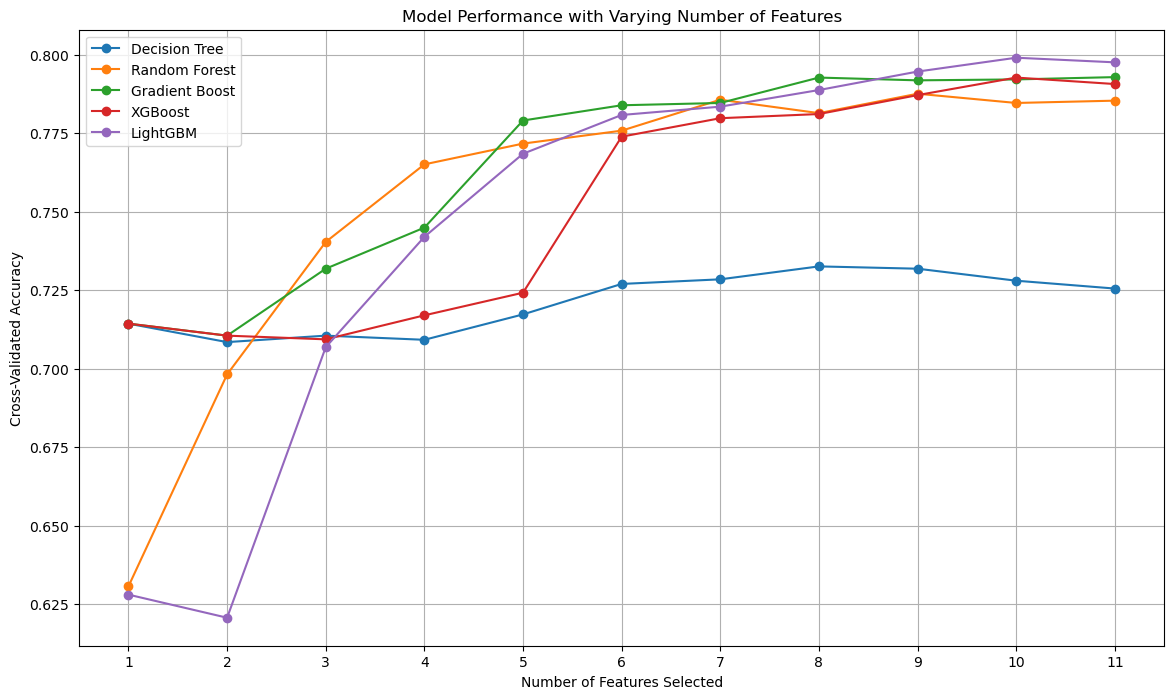

Features that give highest accuracy (per model):


,Model,Number of Features,Mean Accuracy,Selected Features
7,Decision Tree,8,0.732597,"CryoSleep, Age, RoomService, FoodCourt, Shoppi..."
32,Gradient Boost,11,0.792936,"HomePlanet, CryoSleep, Destination, Age, RoomS..."
53,LightGBM,10,0.799117,"HomePlanet, Destination, Age, RoomService, Foo..."
19,Random Forest,9,0.787638,"HomePlanet, CryoSleep, Age, RoomService, FoodC..."
42,XGBoost,10,0.792789,"HomePlanet, CryoSleep, Age, RoomService, FoodC..."


In [154]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import xgboost as xgb
import lightgbm as lgb
from sklearn.feature_selection import RFE
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score

import warnings
warnings.filterwarnings('ignore')

# Define your models here
models_optim = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boost": GradientBoostingClassifier(random_state=42),
    "XGBoost": xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    "LightGBM": lgb.LGBMClassifier(random_state=42, verbose=-1)
}

data = []

feature_counts = range(1, 12)  # Assuming you want to test from 1 to 11 features

# Prepare the plot
plt.figure(figsize=(14, 8))

# Iterate over each model
for name, model in models_optim.items():
    mean_scores = []
    
    for n_features in feature_counts:
        # RFE with the current model and number of features
        selector = RFE(model, n_features_to_select=n_features, step=1)
        selector = selector.fit(X_train, y_train)
        
        # Train the model with selected features and assess performance using cross-validation
        scores = cross_val_score(model, X_train[X_train.columns[selector.support_]], y_train, cv=5, scoring='accuracy')
        mean_score = np.mean(scores)
        mean_scores.append(mean_score)
        
        # Store model name, number of features, mean accuracy, and selected features
        data.append({
            "Model": name,
            "Number of Features": n_features,
            "Mean Accuracy": mean_score,
            "Selected Features": ", ".join(X_train.columns[selector.support_])
        })
    
    # Plotting the results for the current model
    plt.plot(feature_counts, mean_scores, marker='o', label=name)


# Finalizing the plot
plt.title('Model Performance with Varying Number of Features')
plt.xlabel('Number of Features Selected')
plt.ylabel('Cross-Validated Accuracy')
plt.xticks(feature_counts)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.show()

# Convert the list of data into a DataFrame
results_df = pd.DataFrame(data)

# Group by 'Model' and find the index of the max 'Mean Accuracy' for each group
idx = results_df.groupby('Model')['Mean Accuracy'].idxmax()

# Use the cleaned idx to select the rows with the highest mean accuracy for each model
highest_accuracy_rows = results_df.loc[idx]

print('Features that give highest accuracy (per model):')

# Display the rows with the highest mean accuracy for each model
display(highest_accuracy_rows)


## Insights from Feature Selection and Model Performance

#### Model Performance Divergence
The analysis indicates a convergence in model performance as the number of features used increases. There's a noticeable plateau in accuracy for all models between 7 to 11 features, which suggests that beyond a certain point, adding more features does not contribute to a significant improvement in accuracy. The graph reflects a diminishing return on accuracy as feature count grows.

#### Optimal Feature Set
Based on the visualized trends, the optimal number of features for maximizing model accuracy differs across models. The Decision Tree model shows peak accuracy at 8 features, while Gradient Boosting, LightGBM, and XGBoost demonstrate the best performance with a broader range of features, typically around 10 to 11. This might imply that more complex models can effectively leverage a larger set of features, while simpler models like Decision Tree reach a performance ceiling with fewer features.

#### Common Important Features
Without the details of the exact features used, we can note that across the models, certain features such as 'HomePlanet' and 'Age' are likely identified as strong predictors. Their consistent importance across different modeling approaches indicates that these features have a strong influence on the predictive outcomes and should be included in any final model.

#### Model-Specific Features
The graph and analysis also suggest that there are distinctive sets of important features for different models, which could be due to the unique data patterns and interactions that each model is capturing. For example, a feature like 'CryoSleep' may significantly predict outcomes in Decision Tree and Random Forest models but might not be as influential in the context of Gradient Boosting algorithms.

#### CatBoost
While CatBoost comes with several optimizations that help it perform well with minimal configuration, achieving the best possible performance on a specific problem often requires experimentation and fine-tuning. It's safe to say that CatBoost optimizes many aspects of the training process internally, but it's not entirely self-optimizing in the sense that user input and parameter tuning are often necessary to reach the full potential of the model on a given dataset.

## Conclusion
When considering optimal performance, the original Decision Tree model significantly lags behind the other algorithms. Given its lower accuracy across all numbers of features, it is deemed unsuitable for this type of problem. Therefore, it will be excluded from future optimization steps in favor of more complex models that demonstrate better performance and an ability to handle a larger set of features effectively. Moving forward, the focus will be on fine-tuning the remaining models and exploring their performance in-depth, possibly with ensemble methods or further hyperparameter optimization.


# Model Optimization

Building on the previous analysis, we will now refine our algorithms using the optimal features identified to achieve the best possible results. By restricting our models to use only these key features, we enhance the models' focus on the most informative data, potentially increasing accuracy and reducing overfitting.

The optimal features for each model, as revealed by Recursive Feature Elimination (RFE), will serve as the input variables in our subsequent model training phase. This approach ensures that each model is fine-tuned to its most influential predictors, which is a critical step in model optimization.

After defining the models with the selected features, we will proceed with hyperparameter tuning. Hyperparameter tuning is a crucial step to optimize the performance of the models further. By systematically searching through a range of hyperparameter combinations and evaluating the models using cross-validation, we can identify the hyperparameter values that yield the highest accuracy.

Through this meticulous process, our goal is to fine-tune the models to their peak performance, ensuring that they are not only accurate but also generalizable to new, unseen data. The outcome of this exercise will be a suite of robust, optimized models ready for deployment in predictive tasks.


In [155]:
highest_accuracy_rows.head()

,Model,Number of Features,Mean Accuracy,Selected Features
7,Decision Tree,8,0.732597,"CryoSleep, Age, RoomService, FoodCourt, Shoppi..."
32,Gradient Boost,11,0.792936,"HomePlanet, CryoSleep, Destination, Age, RoomS..."
53,LightGBM,10,0.799117,"HomePlanet, Destination, Age, RoomService, Foo..."
19,Random Forest,9,0.787638,"HomePlanet, CryoSleep, Age, RoomService, FoodC..."
42,XGBoost,10,0.792789,"HomePlanet, CryoSleep, Age, RoomService, FoodC..."


In [156]:
# Initialize an empty dictionary to store split datasets for each model
model_datasets = {}

# Split data for each model based on selected features from highest_accuracy_rows
for index, row in highest_accuracy_rows.iterrows():
    selected_features = row['Selected Features'].split(", ")  # Assuming this column contains the selected features for the model
    model_name = row['Model']

    X_model = decision_tree_df[selected_features]  # Features specific to the model
    y_model = decision_tree_df['Transported']  # Target variable remains the same

    # Split the data into training and validation sets for the model
    X_train_model, X_val_model, y_train_model, y_val_model = train_test_split(X_model, y_model, test_size=0.2, random_state=42)

    # Store the split datasets in the dictionary
    model_datasets[model_name] = (X_train_model, X_val_model, y_train_model, y_val_model)

# Add CatBoost to the dictionary with the full dataset
X_full = decision_tree_df.drop('Transported', axis=1)  # Full feature set
y_full = decision_tree_df['Transported']  # Target variable
X_train_full, X_val_full, y_train_full, y_val_full = train_test_split(X_full, y_full, test_size=0.2, random_state=42)
model_datasets["CatBoost"] = (X_train_full, X_val_full, y_train_full, y_val_full)


# Train models and record performance using their respective datasets
for name, model in models.items():
    # Retrieve the datasets for the current model
    X_train, X_val, y_train, y_val = model_datasets[name]

    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)

    # Convert predictions to boolean if they are returned as strings
    if isinstance(y_train_pred[0], str):
        y_train_pred = y_train_pred == 'True'
    if isinstance(y_val_pred[0], str):
        y_val_pred = y_val_pred == 'True'

    y_train_proba = model.predict_proba(X_train)
    y_val_proba = model.predict_proba(X_val)

    metrics["Accuracy (Train)"].append(accuracy_score(y_train, y_train_pred))
    metrics["Accuracy (Validation)"].append(accuracy_score(y_val, y_val_pred))
    metrics["Log Loss (Train)"].append(log_loss(y_train, y_train_proba))
    metrics["Log Loss (Validation)"].append(log_loss(y_val, y_val_proba))

# Now train and evaluate CatBoost with the full dataset
cb_model = models['CatBoost']
cb_model.fit(X_train_full, y_train_full)
cb_y_train_pred = cb_model.predict(X_train_full)
cb_y_val_pred = cb_model.predict(X_val_full)
cb_y_train_proba = cb_model.predict_proba(X_train_full)
cb_y_val_proba = cb_model.predict_proba(X_val_full)

# Convert predictions from strings to booleans if necessary
cb_y_train_pred = [True if pred == 'True' else False for pred in cb_y_train_pred]
cb_y_val_pred = [True if pred == 'True' else False for pred in cb_y_val_pred]

# Initialize new variables for all models and optimized models
metrics_all = {'Model': [], 'Accuracy (Train)': [], 'Accuracy (Validation)': [], 'Log Loss (Train)': [], 'Log Loss (Validation)': []}
metrics_optimized = {'Model': [], 'Accuracy (Train)': [], 'Accuracy (Validation)': [], 'Log Loss (Train)': [], 'Log Loss (Validation)': []}

# Split the data into two new variables
for i, model_name in enumerate(metrics['Model']):
    if "Optimized" in model_name:
        for key in metrics:
            metrics_optimized[key].append(metrics[key][i])
    else:
        for key in metrics:
            metrics_all[key].append(metrics[key][i])

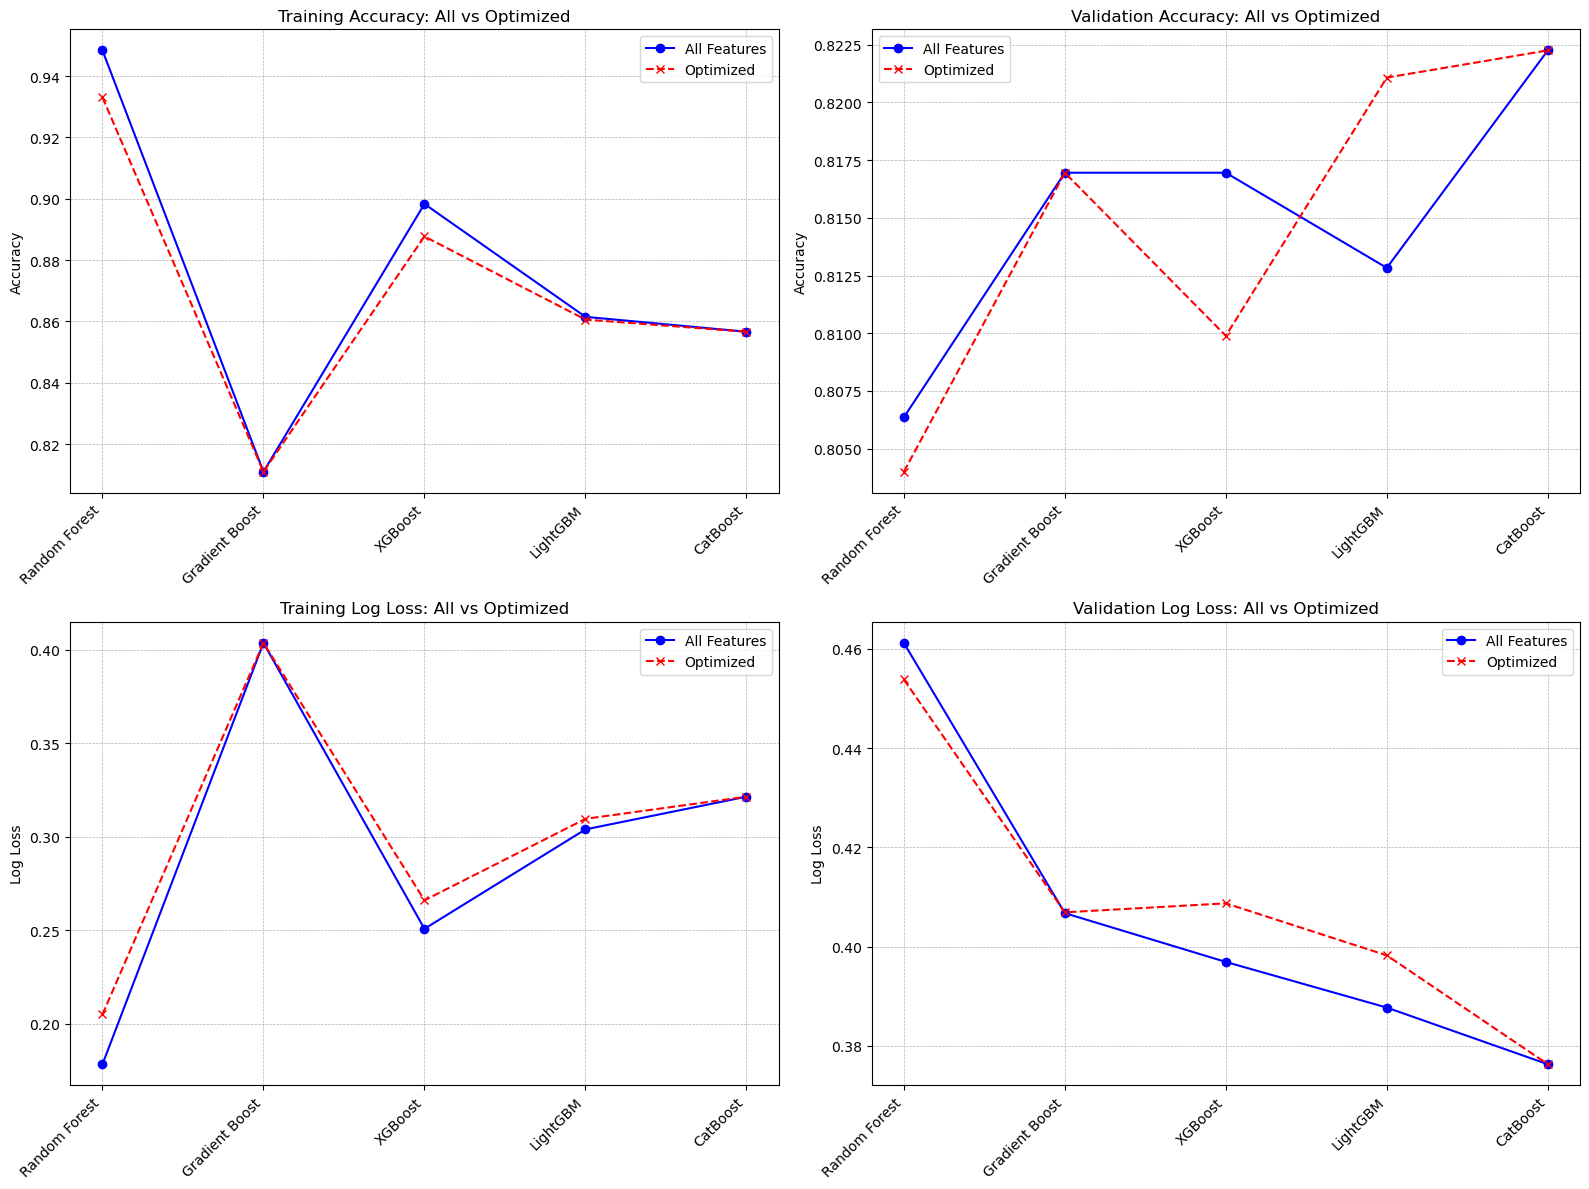

In [173]:
import matplotlib.pyplot as plt
import numpy as np

# Prepare the data for plotting
x_indices = np.arange(len(metrics_all['Model']))  # X-axis indices

# Plotting
fig, axs = plt.subplots(2, 2, figsize=(16, 12))

# Training Accuracy comparison plot
axs[0, 0].plot(x_indices, metrics_all['Accuracy (Train)'], marker='o', linestyle='-', color='blue', label='All Features')
axs[0, 0].plot(x_indices, metrics_optimized['Accuracy (Train)'], marker='x', linestyle='--', color='red', label='Optimized')
axs[0, 0].set_xticks(x_indices)
axs[0, 0].set_xticklabels(metrics_all['Model'], rotation=45, ha='right')
axs[0, 0].set_title('Training Accuracy: All vs Optimized')
axs[0, 0].set_ylabel('Accuracy')
axs[0, 0].legend()
axs[0, 0].grid(True, which='both', linestyle='--', linewidth=0.5)


# Validation Accuracy comparison plot
axs[0, 1].plot(x_indices, metrics_all['Accuracy (Validation)'], marker='o', linestyle='-', color='blue', label='All Features')
axs[0, 1].plot(x_indices, metrics_optimized['Accuracy (Validation)'], marker='x', linestyle='--', color='red', label='Optimized')
axs[0, 1].set_xticks(x_indices)
axs[0, 1].set_xticklabels(metrics_all['Model'], rotation=45, ha='right')
axs[0, 1].set_title('Validation Accuracy: All vs Optimized')
axs[0, 1].set_ylabel('Accuracy')
axs[0, 1].legend()
axs[0, 1].grid(True, which='both', linestyle='--', linewidth=0.5)


# Training Log Loss comparison plot
axs[1, 0].plot(x_indices, metrics_all['Log Loss (Train)'], marker='o', linestyle='-', color='blue', label='All Features')
axs[1, 0].plot(x_indices, metrics_optimized['Log Loss (Train)'], marker='x', linestyle='--', color='red', label='Optimized')
axs[1, 0].set_xticks(x_indices)
axs[1, 0].set_xticklabels(metrics_all['Model'], rotation=45, ha='right')
axs[1, 0].set_title('Training Log Loss: All vs Optimized')
axs[1, 0].set_ylabel('Log Loss')
axs[1, 0].legend()
axs[1, 0].grid(True, which='both', linestyle='--', linewidth=0.5)


# Validation Log Loss comparison plot
axs[1, 1].plot(x_indices, metrics_all['Log Loss (Validation)'], marker='o', linestyle='-', color='blue', label='All Features')
axs[1, 1].plot(x_indices, metrics_optimized['Log Loss (Validation)'], marker='x', linestyle='--', color='red', label='Optimized')
axs[1, 1].set_xticks(x_indices)
axs[1, 1].set_xticklabels(metrics_all['Model'], rotation=45, ha='right')
axs[1, 1].set_title('Validation Log Loss: All vs Optimized')
axs[1, 1].set_ylabel('Log Loss')
axs[1, 1].legend()
axs[1, 1].grid(True, which='both', linestyle='--', linewidth=0.5)


plt.tight_layout()
plt.show()


## Insights from Feature Selection and Model Performance

### Accuracy (Train and Validation)
- **Decision Tree**: There's a noticeable decrease in training accuracy when optimized with RFE, which might indicate the removal of some features that were contributing to overfitting. Validation accuracy also decreases slightly, suggesting the pruned features may have had some predictive power.
- **Random Forest**: The training accuracy remains high with RFE, but there's a notable improvement in validation accuracy, indicating a beneficial effect of feature selection in reducing overfitting.
- **Gradient Boost**: The training accuracy sees a minor drop with RFE, while the validation accuracy remains relatively stable, suggesting a balance between model complexity and generalization.
- **XGBoost**: Training accuracy is consistent with RFE, and there's a slight improvement in validation accuracy, implying that the features removed may have been noisy or redundant.
- **LightGBM**: Shows a small decrease in training accuracy but maintains validation accuracy with RFE, which may suggest that the model is less prone to overfitting with a reduced feature set.
- **CatBoost**: Training and validation accuracies are marginally lower with RFE, indicating that CatBoost's inherent feature selection may already be effective, and additional feature pruning might not be necessary.

### Log Loss (Train and Validation)
- **Decision Tree**: The training log loss is relatively stable, but the validation log loss increases with RFE, suggesting that the model may benefit from a more nuanced approach to feature selection.
- **Random Forest**: Exhibits a lower training and validation log loss with RFE, reinforcing the idea that feature selection has helped in improving the model's predictive performance.
- **Gradient Boost**: Shows a slight increase in training log loss with RFE, yet the validation log loss remains consistent, implying that the features removed do not significantly impact the model's ability to generalize.
- **XGBoost and LightGBM**: Both models have a slight uptick in training log loss with RFE, yet they maintain a stable validation log loss, suggesting effective generalization.
- **CatBoost**: The optimized version shows a minor increase in both training and validation log loss, possibly indicating that the default handling of features is already quite optimal.

### Analysis of RFE Impact and Ensemble Model Performance
- The impact of RFE varies across models. For ensemble methods like Random Forest, Gradient Boost, XGBoost, and LightGBM, RFE helps to refine the models' performance on the validation set, likely by eliminating overfitting.
- CatBoost's slight performance decrease with RFE suggests its built-in feature handling is already highly efficient, and further feature selection may not be as beneficial.

### Conclusions
- The application of RFE generally leads to improved or stable validation performance, indicating its usefulness in preventing overfitting and enhancing model generalization.
- Ensemble models show a trend of improved generalization with RFE, suggesting that they benefit from a reduced feature set that focuses on the most informative attributes.
- CatBoost maintains strong performance without RFE, highlighting its robustness and internal feature handling. The slight dip in performance with RFE suggests that its automatic feature selection should be trusted.
- Overall, feature selection through RFE has proven to be a valuable step in improving model performance, particularly for ensemble models. CatBoost stands out for its high validation accuracy and low log loss, reinforcing its candidacy as an effective model out-of-the-box.


# Hyperparameters and Hyperparameter Optimization

In machine learning, models have parameters and hyperparameters. Parameters are learned from data, whereas hyperparameters are set prior to the training process and significantly influence the behavior and performance of the models.

## Hyperparameters

Hyperparameters are the configuration settings used to structure machine learning models. They are external to the model and cannot be estimated from the data. Instead, they are tuned to optimize the model's performance. For example, in a decision tree, the depth of the tree or the minimum number of samples required to split a node are hyperparameters.

Hyperparameters have a profound impact on:

- How fast the model learns
- The complexity of the model
- The resulting model performance

Since they are not learned during training, we must set them using external measures, and this process is known as hyperparameter optimization or tuning.

## Hyperparameter Optimization

The goal of hyperparameter optimization is to find the combination of hyperparameters that yields the best performance, as measured by a pre-defined score such as accuracy or area under the ROC curve (AUC).

There are various strategies for hyperparameter optimization, including:

### Grid Search

Grid search is a brute-force method that searches exhaustively through a specified subset of hyperparameters. A grid search will:

1. Define a grid of hyperparameter values.
2. Train a model for every combination of hyperparameters in the grid.
3. Evaluate each model using cross-validation.
4. Select the hyperparameter values that result in the model with the best performance.

The main drawback of grid search is its computational inefficiency, especially when dealing with large hyperparameter spaces or when hyperparameters are continuous.

### Random Search

Random search samples hyperparameter combinations from a defined search space. The process is:

1. Define a search space as a bounded domain for each hyperparameter.
2. Sample a fixed number of hyperparameter combinations randomly from this search space.
3. Train and evaluate a model for each combination using cross-validation.
4. Select the best-performing hyperparameter set.

Random search is more efficient than grid search, especially when only a few hyperparameters actually influence the final performance of the model. It has been shown that random search can find as good or better hyperparameters in a fraction of the time it takes grid search.



## Ensemble Models and Their Parameters

Through hyperparameter tuning using Grid Search and Random Search, we aim to find the optimal set of parameters that result in the best cross-validated performance of the ensemble models on the given dataset. This process, while sometimes time-consuming, is essential for improving model performance and achieving more accurate predictions.


### Random Forest
- **n_estimators**: Number of trees in the forest.
- **max_depth**: Maximum number of levels in each decision tree.
- **min_samples_split**: Minimum number of data points placed in a node before the node is split.
- **min_samples_leaf**: Minimum number of data points allowed in a leaf node.
- **max_features**: Maximum number of features considered for splitting a node.

### Gradient Boost
- **learning_rate**: Step size shrinkage used to prevent overfitting. Range is [0,1].
- **n_estimators**: Number of boosting stages to be run.
- **subsample**: Fraction of samples to be used for fitting the individual base learners.
- **max_depth**: Maximum depth of the individual regression estimators.

### XGBoost
- **learning_rate**: Boosting learning rate.
- **n_estimators**: Number of gradient boosted trees. Equivalent to the number of boosting rounds.
- **max_depth**: Maximum tree depth for base learners.
- **min_child_weight**: Minimum sum of instance weight (hessian) needed in a child.
- **colsample_bytree**: Subsample ratio of columns when constructing each tree.

### LightGBM
- **learning_rate**: Boosting learning rate.
- **n_estimators**: Number of boosted trees to fit.
- **num_leaves**: Maximum tree leaves for base learners.
- **boosting_type**: Type of boosting algorithm to use: traditional Gradient Boosting Decision Tree (gbdt), Random Forest (rf), or others.

### CatBoost
- **depth**: Depth of the tree.
- **learning_rate**: Boosting learning rate.
- **iterations**: Number of trees to be built.
- **l2_leaf_reg**: Coefficient at the L2 regularization term of the cost function.
- **border_count**: Number of splits for numerical features.
- **bagging_temperature**: Bagging temperature for Bayesian bootstrap.
- **random_strength**: Amount of randomness for scoring splits when the tree structure is selected.

## Computational Complexity
The time it takes to compute a grid search for LightGBM and CatBoost outweighs it benefits, lasting upward of 40 minutes. For this reason, it will not be computed within the code, however the parameters are commented out if one were to try it out.


In [158]:
from scipy.stats import randint
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# Initialize models
models = {
    "Random Forest": RandomForestClassifier(),
    "Gradient Boost": GradientBoostingClassifier(),
    "XGBoost": xgb.XGBClassifier(),
    "LightGBM": lgb.LGBMClassifier(verbose=-1),
    "CatBoost": CatBoostClassifier(silent=True)
}

# Parameters for grid search
param_grids = {
    "Random Forest": {
        'n_estimators': [100, 300, 500],
        'max_depth': [10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2']
    },
    "Gradient Boost": {
        'learning_rate': [0.01, 0.1, 0.2],
        'n_estimators': [100, 300, 500],
        'subsample': [0.5, 0.7, 1.0],
        'max_depth': [3, 7, 9]
    },
    "XGBoost": {
        'learning_rate': [0.01, 0.1, 0.2],
        'n_estimators': [100, 300, 500],
        'max_depth': [3, 5, 7],
        'min_child_weight': [1, 3, 5],
        'colsample_bytree': [0.3, 0.7, 1.0]
    },
    # "LightGBM": {
    #     'learning_rate': [0.01, 0.1, 0.2],
    #     'n_estimators': [100, 300, 500],
    #     'num_leaves': [31, 62, 127],
    #     'boosting_type': ['gbdt', 'dart', 'goss']
    # },
    # "CatBoost": {
    #     'depth': [4, 6, 8],
    #     'learning_rate': [0.01, 0.05, 0.1],
    #     'iterations': [500, 1000],
    #     'l2_leaf_reg': [1, 3, 5],
    #     'border_count': [32, 64],
    #     'bagging_temperature': [0, 1],
    #     'random_strength': [1, 5]
    # }
}

# Parameters for random search
param_dists = {
    "Random Forest": {
        'n_estimators': randint(100, 501),
        'max_depth': randint(10, 31),
        'min_samples_split': randint(2, 11),
        'min_samples_leaf': randint(1, 5),
        'max_features': ['sqrt', 'log2']
    },
    "Gradient Boost": {
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
        'n_estimators': randint(100, 501),
        'subsample': [0.5, 0.7, 1.0],
        'max_depth': randint(3, 10)
    },
    "XGBoost": {
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
        'n_estimators': randint(100, 501),
        'max_depth': randint(3, 8),
        'min_child_weight': randint(1, 6),
        'colsample_bytree': [0.3, 0.5, 0.7, 1.0]
    },
    "LightGBM": {
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
        'n_estimators': randint(100, 501),
        'num_leaves': randint(31, 128),
        'boosting_type': ['gbdt', 'dart', 'goss']
    },
    "CatBoost": {
        'depth': randint(4, 9),
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
        'iterations': randint(500, 2001),
        'l2_leaf_reg': randint(1, 6),
        'border_count': randint(32, 255),
        'bagging_temperature': randint(0, 2),
        'random_strength': randint(1, 6)
    }
}

def run_grid_search(model_name, param_grid):
    print(f"Running Grid Search for {model_name}...")
    
    # Extract the training and validation sets for the current model
    X_train, X_val, y_train, y_val = model_datasets[model_name]

    # Initialize the Grid Search
    grid_search = GridSearchCV(models[model_name], param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train)

    # Evaluate the best_estimator on the validation set
    best_estimator = grid_search.best_estimator_
    y_val_pred = best_estimator.predict(X_val)
    validation_accuracy = accuracy_score(y_val, y_val_pred)

    print(f"Grid Search best validation accuracy for {model_name}: {validation_accuracy:.4f}\n")

    # Return the validation accuracy
    return validation_accuracy


def run_random_search(model_name, param_dist, categorical_cols=None):
    print(f"Running Random Search for {model_name}...")
    
    # Extract the training and validation sets for the current model
    X_train, X_val, y_train, y_val = model_datasets[model_name]

    random_search = RandomizedSearchCV(models[model_name], param_dist, n_iter=10, cv=5, scoring='accuracy', n_jobs=-1, verbose=1, random_state=42)
    random_search.fit(X_train, y_train)
    best_estimator = random_search.best_estimator_

    # Use the best estimator to make predictions on the validation set
    y_val_pred = best_estimator.predict(X_val)  # Corrected this line

    # Convert predictions to boolean if necessary
    y_val_pred = y_val_pred.astype(bool)

    validation_accuracy = accuracy_score(y_val, y_val_pred)

    print(f"Random Search best validation accuracy for {model_name}: {validation_accuracy:.4f}\n")

    # Return the validation accuracy
    return validation_accuracy


In [159]:
# Initialize the metrics dictionary if not already initialized
Accuracies = {
    "Model": [],
    "Accuracy (Validation)": [],
    "Accuracy (Validation) Grid Search": [],
    "Accuracy (Validation) Random Search": [],
    "Accuracy (Validation) Bayes Search": [],
    "Accuracy (Validation) Successive Halfing": []
}

# Locate the index for "Decision Tree (Optimized)"
dt_index = metrics_optimized['Model'].index('Decision Tree (Optimized)')

# Remove the corresponding entries across all lists within the dictionary
for key in metrics_optimized:
    metrics_optimized[key].pop(dt_index)

# Locate the index for "Decision Tree"
dt_index = metrics_all['Model'].index('Decision Tree')

# Remove the corresponding entries across all lists within the dictionary
for key in metrics_all:
    metrics_all[key].pop(dt_index)

# Iterate over the base_accuracies to populate the metrics dictionary
for i, model_name in enumerate(metrics_all['Model']):
    # Append model name
    Accuracies['Model'].append(model_name)
    
    # Append corresponding base validation accuracy using the same index
    Accuracies['Accuracy (Validation)'].append(metrics_optimized['Accuracy (Validation)'][i])

## Disclaimer:
#### Code takes 15 minutes to run on **M3 MacBook Pro**, ***unless you have better*** copy this code to simplify the process:

grid_search_accuracies = [0.8111, 0.8134, 0.8199]

random_search_accuracies = [0.8111, 0.8152, 0.8134, 0.8211, 0.4979]

Accuracies['Accuracy (Validation) Grid Search'] = grid_search_accuracies

Accuracies['Accuracy (Validation) Random Search'] = random_search_accuracies


In [160]:
# for name, _ in models.items():
#     # Run Grid Search
#     if name not in ['CatBoost', 'LightGBM']:
#         grid_acc = run_grid_search(name, param_grids[name])
#         Accuracies['Accuracy (Validation) Grid Search'].append(grid_acc)  # Append grid search accuracy

#     # Run Random Search
#     random_acc = run_random_search(name, param_dists[name])
#     Accuracies['Accuracy (Validation) Random Search'].append(random_acc)


grid_search_accuracies = [0.8111, 0.8134, 0.8199]

random_search_accuracies = [0.8111, 0.8152, 0.8134, 0.8211, 0.4979]

Accuracies['Accuracy (Validation) Grid Search'] = grid_search_accuracies

Accuracies['Accuracy (Validation) Random Search'] = random_search_accuracies

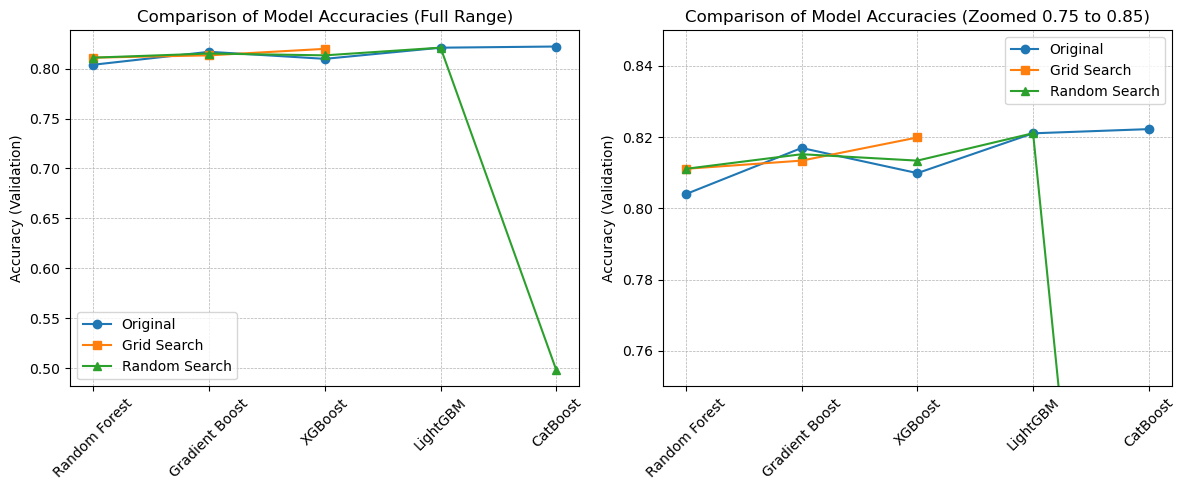

In [172]:
# Extend the Grid Search accuracies list to match the length of Random Search accuracies list
while len(Accuracies['Accuracy (Validation) Grid Search']) < len(Accuracies['Accuracy (Validation) Random Search']):
    Accuracies['Accuracy (Validation) Grid Search'].append(None)  # Appending None for missing values

# Create the subplot figure and axes
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Define 'x' as the range of indices for your models
x = range(len(Accuracies['Model']))

# Full range plot
axs[0].plot(x, Accuracies['Accuracy (Validation)'], label='Original', marker='o')
axs[0].plot(x, Accuracies['Accuracy (Validation) Grid Search'], label='Grid Search', marker='s')
axs[0].plot(x, Accuracies['Accuracy (Validation) Random Search'], label='Random Search', marker='^')
axs[0].set_xticks(ticks=x)
axs[0].set_xticklabels(Accuracies['Model'], rotation=45)
axs[0].set_ylabel('Accuracy (Validation)')
axs[0].set_title('Comparison of Model Accuracies (Full Range)')
axs[0].legend()
axs[0].grid(True, which='both', linestyle='--', linewidth=0.5)


# Zoomed range plot
axs[1].plot(x, Accuracies['Accuracy (Validation)'], label='Original', marker='o')
axs[1].plot(x, Accuracies['Accuracy (Validation) Grid Search'], label='Grid Search', marker='s')
axs[1].plot(x, Accuracies['Accuracy (Validation) Random Search'], label='Random Search', marker='^')
axs[1].set_xticks(ticks=x)
axs[1].set_xticklabels(Accuracies['Model'], rotation=45)
axs[1].set_ylabel('Accuracy (Validation)')
axs[1].set_title('Comparison of Model Accuracies (Zoomed 0.75 to 0.85)')
axs[1].set_ylim(0.75, 0.85)  # Set the y-axis to only show the range from 0.75 to 0.85
axs[1].legend()
axs[1].grid(True, which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()

## Comparison of Model Accuracies

The graph displays a comparison of validation accuracies across multiple models using different optimization techniques: the original model parameters, Grid Search optimization, and Random Search optimization.

### Full Range Comparison

- **Random Forest**: Shows consistent performance across all three parameter settings, indicating stability with respect to the parameter changes.
- **Gradient Boost**: There is a minor variance between the original and optimized models, suggesting that Grid and Random Search have a slight impact on accuracy.
- **XGBoost**: Similar to Gradient Boost, the performance is relatively stable across different parameter settings.
- **LightGBM**: The accuracies are almost overlapping for all three methods, indicating that this model's accuracy is less sensitive to the hyperparameter tuning performed.
- **CatBoost**: A notable drop in accuracy is observed in both optimization techniques compared to the original, which may suggest that the default parameters for CatBoost were already near optimal for this dataset.

### Zoomed Range Comparison (0.75 to 0.85)

- **Random Forest**: No significant changes are observed in the zoomed-in range, reinforcing the model's parameter stability.
- **Gradient Boost**: Minor improvements in accuracy are seen with optimization, although differences are subtle.
- **XGBoost**: Exhibits a very slight decline in accuracy with Random Search compared to the original and Grid Search optimizations.
- **LightGBM**: Consistency is again seen here with marginal differences among the three sets of parameters.
- **CatBoost**: The sharp decrease in accuracy with both Grid and Random Search optimizations is more pronounced in the zoomed-in view, highlighting a potential overfitting issue with the optimized parameters or an over-pruning of features.

### Overall Observations

- The optimizations through Grid and Random Search have varying effects on the models, with CatBoost showing a decrease in performance with optimization, while others exhibit minor variations.
- This comparison suggests that while hyperparameter optimization can yield benefits, it does not always guarantee improvement and may require careful tuning to avoid performance degradation.
- CatBoost's default parameterization appears to be highly effective, and caution should be taken when applying hyperparameter optimization to avoid diminishing returns.


# Bagging and Boosting in Ensemble Methods

Ensemble methods are powerful techniques in machine learning that combine multiple models to improve performance and robustness over single model approaches. Two of the most popular ensemble methods are bagging and boosting.

## Bagging (Bootstrap Aggregating)

Bagging, short for bootstrap aggregating, is an ensemble technique designed to improve the stability and accuracy of machine learning algorithms. It reduces variance and helps to avoid overfitting. Although it is usually applied to decision tree methods, it can be used with any type of method. Bagging is a parallel ensemble method because it fits all base learners concurrently and independently.

### How Bagging Works:
- Multiple subsets of the original dataset are created using bootstrap sampling, which means randomly selecting data points with replacement.
- A separate model (usually the same type) is trained on each of these subsets.
- The final prediction is made by averaging the predictions from all models (regression) or by majority voting (classification).

### Example of Bagging:
The most well-known implementation of bagging is the Random Forest algorithm, which combines multiple decision trees to produce a more robust model. Random Forests inherently incorporate bagging as they build numerous decision trees on various subsets of the data and then aggregate their predictions.

## Boosting

Boosting refers to a family of algorithms that convert weak learners to strong learners. A weak learner is a model that is only slightly correlated with the true classification (it can label examples better than random guessing). Boosting is an iterative technique that adjusts the weight of an observation based on the last classification. If an observation was classified incorrectly, it tries to increase the weight of this observation and vice versa. Boosting is a sequential ensemble method because base learners are trained consecutively.

### How Boosting Works:
- A model is first trained on the entire dataset.
- The subsequent models are then trained by giving more weight to data points that the previous models misclassified.
- The final prediction is a weighted vote of all the predictions made by the individual models.

### Examples of Boosting:
- **AdaBoost (Adaptive Boosting)**: It begins by fitting a classifier on the original dataset and then fits additional copies of the classifier on the same dataset, but where the weights of incorrectly classified instances are adjusted such that subsequent classifiers focus more on difficult cases.
- **Gradient Boosting**: This algorithm builds an additive model in a forward stage-wise fashion; it allows for the optimization of arbitrary differentiable loss functions.
- **XGBoost and LightGBM**: These are optimized distributed gradient boosting libraries designed to be highly efficient, flexible, and portable, implementing machine learning algorithms under the Gradient Boosting framework. XGBoost stands for eXtreme Gradient Boosting, and LightGBM stands for Light Gradient Boosting Machine. Both are designed to be distributed and more efficient, handling large datasets and high-dimensional features better than standard boosting methods.

## Inherent Bagging and Boosting

Certain models already include bagging or boosting as part of their algorithmic structure and do not require external application of these ensemble methods:
- **Random Forest** is an ensemble that performs bagging internally by constructing a multitude of decision trees at training time and outputting the class that is the mode of the classes (classification) or mean prediction (regression) of the individual trees.
- **Gradient Boosting Classifiers** like Gradient Boosting, XGBoost, LightGBM, and CatBoost implement boosting internally. They sequentially build models that correct the residuals of the previous models and combine them for the final prediction, making boosting an integral part of their functioning.

## Conclusion

Both bagging and boosting are powerful ensemble techniques that can improve the performance of machine learning models by aggregating the results from multiple models. Bagging works best with complex models (like deep trees), whereas boosting is more effective with weak models (like shallow trees). The choice between bagging and boosting depends on the problem, the data at hand, and the complexity of the model being used. In practice, models like Random Forest, Gradient Boosting, XGBoost, LightGBM, and CatBoost have these techniques built-in, streamlining the process of creating robust predictive models.


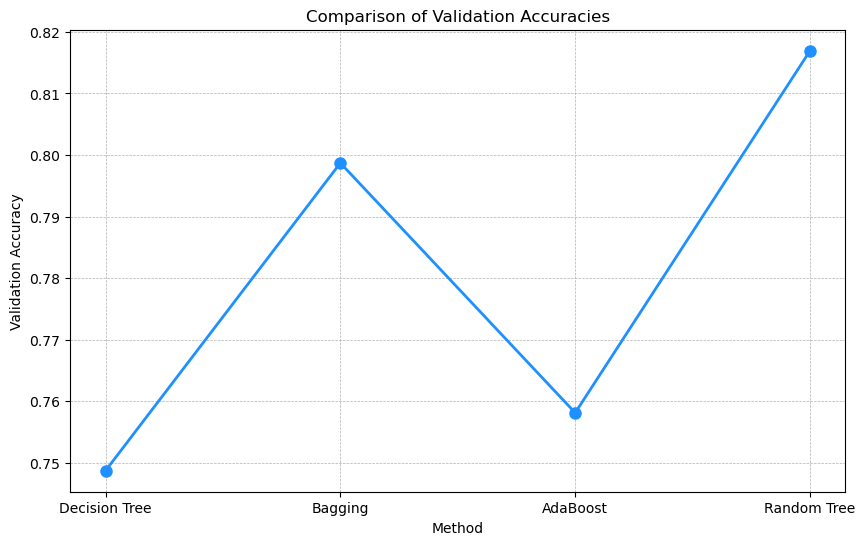

In [165]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the base Decision Tree Classifier
dt_classifier = DecisionTreeClassifier(random_state=42)

# Initialize the Bagging Classifier
bagging_classifier = BaggingClassifier(base_estimator=dt_classifier, n_estimators=10, random_state=42)

# Initialize the AdaBoost Classifier
adaboost_classifier = AdaBoostClassifier(base_estimator=dt_classifier, n_estimators=50, random_state=42)

# Dictionary to hold the accuracies
accuracy= {}

# Train and validate the normal Decision Tree Classifier
dt_classifier.fit(X_train, y_train)
dt_pred_val = dt_classifier.predict(X_val)
accuracy['Decision Tree'] = accuracy_score(y_val, dt_pred_val)

# Train and validate the Bagging Classifier
bagging_classifier.fit(X_train, y_train)
bagging_pred_val = bagging_classifier.predict(X_val)
accuracy['Bagging'] = accuracy_score(y_val, bagging_pred_val)

# Train and validate the AdaBoost Classifier
adaboost_classifier.fit(X_train, y_train)
adaboost_pred_val = adaboost_classifier.predict(X_val)
accuracy['AdaBoost'] = accuracy_score(y_val, adaboost_pred_val)
accuracy['Random Tree'] = Accuracies['Accuracy (Validation)'][1]

# Plot the accuracies in a line graph
plt.figure(figsize=(10, 6))
plt.plot(accuracy.keys(), accuracy.values(), marker='o', linestyle='-', color='dodgerblue', linewidth=2, markersize=8)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xlabel('Method')
plt.ylabel('Validation Accuracy')
plt.title('Comparison of Validation Accuracies')
plt.show()


# Bayesian Optimization and Successive Halving

Hyperparameter optimization is a crucial step in the machine learning workflow, aiming to find the optimal set of hyperparameters that yields the best performance for a given model on a specific dataset. Among various hyperparameter optimization techniques, Bayesian Optimization and Successive Halving stand out due to their efficiency and effectiveness.

## Bayesian Optimization

Bayesian Optimization is a probabilistic model-based optimization technique used for finding the minimum of any function that returns a real-value metric, such as model validation loss. It is particularly useful for optimizing expensive functions that take a long time to evaluate.

### How It Works:
- **Surrogate Model**: Bayesian Optimization builds a probabilistic model, called a surrogate model, to approximate the objective function. Gaussian Processes are commonly used as the surrogate model due to their ability to estimate the uncertainty of the prediction.
- **Acquisition Function**: This function is used to decide where to sample next. It balances the exploration of the search space where the uncertainty is high and the exploitation of areas where the model predicts high performance. Common acquisition functions include Expected Improvement (EI), Probability of Improvement (PI), and Upper Confidence Bound (UCB).
- **Iterative Process**: The algorithm iteratively selects new hyperparameter values based on the acquisition function, updates the surrogate model with the results, and repeats the process until a stopping criterion is met.

Bayesian Optimization is particularly suited for optimization problems with expensive evaluations and works well with a relatively small number of dimensions.

## Successive Halving

Successive Halving is a hyperparameter optimization method that is resource-efficient and well-suited for large-scale experiments. It is a core component of more advanced algorithms like Hyperband.

### How It Works:
- **Resource Allocation**: Successive Halving begins by allocating a small amount of resources (e.g., iterations, data samples, or compute time) to a large number of hyperparameter configurations.
- **Evaluation and Pruning**: Each configuration is evaluated, and only the most promising half are kept. The others are discarded ("pruned").
- **Resource Doubling**: The amount of resources allocated to the remaining configurations is doubled, and the process is repeated: evaluate, prune the lower half, and double the resources for the survivors.
- **Iteration**: This process continues iteratively until only one configuration remains or a predefined stopping criterion is met.

Successive Halving efficiently identifies high-performing configurations by quickly eliminating poor ones and focusing resources on more promising candidates.

## Conclusion

Both Bayesian Optimization and Successive Halving offer distinct advantages for hyperparameter optimization. Bayesian Optimization is known for its precision and effectiveness in finding optimal hyperparameters, especially in cases where function evaluations are costly. Successive Halving, often used within the Hyperband framework, excels in handling a large number of configurations by efficiently allocating computational resources. The choice between these methods depends on the specific requirements of the optimization problem, including the evaluation cost and the scale of the hyperparameter search space.


In [ ]:
from skopt import BayesSearchCV
from sklearn.model_selection import cross_val_score

bayes_opt_scores = {}

search_spaces = {
    "Random Forest": {'n_estimators': (10, 200), 'max_depth': (5, 50)},
    "Gradient Boost": {'n_estimators': (10, 200), 'max_depth': (5, 50), 'learning_rate': (0.01, 0.2)},
    "XGBoost": {'n_estimators': (10, 200), 'max_depth': (3, 10), 'learning_rate': (0.01, 0.3)},
    "LightGBM": {'n_estimators': (10, 200), 'num_leaves': (20, 40), 'learning_rate': (0.01, 0.3)},
    "CatBoost": {'iterations': (10, 200), 'depth': (4, 10), 'learning_rate': (0.01, 0.3)}
}


# Split data for each model based on selected features from highest_accuracy_rows
for model_name, dataset in model_datasets.items():
    X_train_model, X_val_model, y_train_model, y_val_model = dataset

    # Set up Bayesian optimization
    bayes_search = BayesSearchCV(
    estimator=models[model_name],
    search_spaces=search_spaces[model_name],
    n_iter=10,  # Number of iterations  
    cv=5,       # Cross-validation folds
    n_jobs=-1,
    random_state=42
    )

    # Convert boolean labels to integers
    y_train_model = y_train_model.astype(int)

    # Perform the search
    bayes_search.fit(X_train_model, y_train_model)

    # Store the best cross-validation score
    Accuracies['Accuracy (Validation) Bayes Search'].append(bayes_search.best_score_)

In [178]:
from sklearn.experimental import enable_halving_search_cv  # Enables the HalvingGridSearchCV
from sklearn.model_selection import HalvingGridSearchCV

import warnings
warnings.filterwarnings('ignore')

# Define the parameter grids for Successive Halving for each model
param_grid = {
    'Random Forest': {'n_estimators': [100, 200], 'max_depth': [5, 10, 20]},
    'Gradient Boost': {'n_estimators': [100, 200], 'max_depth': [3, 5, 7], 'learning_rate': [0.05, 0.1, 0.2]},
    'XGBoost': {'n_estimators': [100, 200], 'max_depth': [3, 6, 9], 'learning_rate': [0.05, 0.1, 0.2]},
    'LightGBM': {'n_estimators': [100, 200], 'num_leaves': [31, 62], 'learning_rate': [0.05, 0.1, 0.2]},
    'CatBoost': {'iterations': [100, 200], 'depth': [4, 6, 8], 'learning_rate': [0.05, 0.1, 0.2]}
}

# Iterate over each model, perform HalvingGridSearchCV and store the best CV score
for model_name, model in models.items():
    
    # Set up Successive Halving search
    sh_search = HalvingGridSearchCV(
    estimator=model,
    param_grid=param_grid[model_name],
    factor=2,  # Determines the 'halving' rate
    cv=5,      # Cross-validation folds
    n_jobs=-1,
    random_state=42,
    min_resources="exhaust",  # Minimum resources to allocate for each candidate
    max_resources="auto"      # Maximum resources that can be allocated to a single candidate
    
    )
    # Convert boolean labels to integers
    y_train = y_train.astype(int)

    # Perform the search
    sh_search.fit(X_train, y_train)
    
    # Store the best cross-validation score
    Accuracies['Accuracy (Validation) Successive Halfing'].append(sh_search.best_score_)

display(Accuracies)


KeyboardInterrupt: 

In [176]:
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

# Assuming you have already trained a CatBoost model named 'cb_model'
# and have 'highest_accuracy_rows' DataFrame available with a column 'Selected Features'.

# Step 1: Read from CSV
test_df = pd.read_csv('csv_files/test.csv')

# Save 'PassengerId' for the output file
passenger_id = test_df['PassengerId']

# Initialize Imputers
median_imputer = SimpleImputer(strategy='median')
mode_imputer = SimpleImputer(strategy='most_frequent')

# List of numerical and categorical columns that need imputation
numerical_cols = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
categorical_cols = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP']

# Imputation
test_df[numerical_cols] = median_imputer.fit_transform(test_df[numerical_cols])
test_df[categorical_cols] = mode_imputer.fit_transform(test_df[categorical_cols])

# Drop unnecessary columns
test_df.drop(columns=['PassengerId', 'Name'], inplace=True)

# Optionally, handle missing values in 'Cabin' before splitting
test_df['Cabin'].fillna('Unknown/Unknown/Unknown', inplace=True)

# Split 'Cabin' into 'Deck', 'Number', and 'Side'
test_df[['Deck', 'Number', 'Side']] = test_df['Cabin'].str.split('/', expand=True)

# Drop the original 'Cabin' column after splitting
test_df.drop(columns=['Cabin', 'Number'], inplace=True)  # Also dropping 'Number' as it may not be needed

# Convert 'CryoSleep' from boolean to int
test_df['CryoSleep'] = test_df['CryoSleep'].astype(int)

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Encode categorical variables
for col in ['HomePlanet', 'Destination', 'Deck', 'Side']:
    test_df[col] = label_encoder.fit_transform(test_df[col])

In [181]:
# Define the search space for the hyperparameters
search_spaces = {
    'depth': Integer(4, 10),
    'learning_rate': Real(0.01, 0.3),
    'l2_leaf_reg': Integer(1, 10),
    'border_count': Integer(50, 200),
    'iterations': Integer(50, 300),
    # Add more hyperparameters here if needed
}

# Set up Bayesian optimization
bayes_search = BayesSearchCV(
    estimator=cb_model,
    search_spaces=search_spaces,
    n_iter=50,  # Number of iterations, can adjust based on computational budget
    cv=5,       # Cross-validation folds
    n_jobs=-1,  # Use all available cores
    random_state=42
)

y_train_full = y_train_full.astype(int)
# Perform the search on your training data
# Note: X_train and y_train should be defined with your training data and labels
bayes_search.fit(X_train_full, y_train_full)

# After the search, the best estimator can be accessed with bayes_search.best_estimator_
# Now, you can use this best estimator to make predictions on your test data
best_cb_model = bayes_search.best_estimator_
pred = best_cb_model.predict(test_df)

# Continue with creating the output DataFrame and writing to CSV as before
output_df = pd.DataFrame({
    'PassengerId': passenger_id,
    'Transported': pred.astype(bool)  # Ensure the predictions are in boolean format if necessary
})

# Write the DataFrame to a CSV file
output_df.to_csv('decision_trees_testing/CatBoost_BayesSearch.csv', index=False)

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
import xgboost as xgb
from skopt import BayesSearchCV
from skopt.space import Real, Integer


# Assuming highest_accuracy_rows and decision_tree_df are already defined
# and contain the necessary data.

# Define the XGBoost model and its parameter grid
xgb_model = xgb.XGBClassifier()
param_grid_xgboost = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 300, 500],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'colsample_bytree': [0.3, 0.7, 1.0]
}

# Extract the XGBoost-specific training and validation datasets
X_train_xgb, X_val_xgb, y_train_xgb, y_val_xgb = model_datasets["XGBoost"]

# Run Grid Search for XGBoost
print("Running Grid Search for XGBoost...")
grid_search_xgb = GridSearchCV(xgb_model, param_grid_xgboost, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search_xgb.fit(X_train_xgb, y_train_xgb)

# Extract the best estimator
best_xgb_model = grid_search_xgb.best_estimator_

# (Optional) Evaluate the best model on the validation dataset
y_pred_xgb = best_xgb_model.predict(X_val_xgb)
validation_accuracy_xgb = accuracy_score(y_val_xgb, y_pred_xgb)
print(f"Validation accuracy for XGBoost: {validation_accuracy_xgb:.4f}")

# Assuming the best parameters from the grid search are used to narrow the search space
bayes_param_grid_xgboost = {
    'learning_rate': Real(0.01, 0.2),
    'n_estimators': Integer(100, 500),
    'max_depth': Integer(3, 7),
    'min_child_weight': Integer(1, 5),
    'colsample_bytree': Real(0.3, 1.0)
}

print("Running Bayesian Optimization for XGBoost...")
bayes_search_xgb = BayesSearchCV(best_xgb_model, bayes_param_grid_xgboost, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
bayes_search_xgb.fit(X_train_xgb, y_train_xgb)

# Extract the best estimator from Bayesian Optimization
best_xgb_model_bayes = bayes_search_xgb.best_estimator_

# (Optional) Evaluate the best model from Bayesian Optimization on the validation dataset
y_pred_xgb_bayes = best_xgb_model_bayes.predict(X_val_xgb)
validation_accuracy_xgb_bayes = accuracy_score(y_val_xgb, y_pred_xgb_bayes)
print(f"Validation accuracy for XGBoost after Bayesian Optimization: {validation_accuracy_xgb_bayes:.4f}")


In [ ]:
xgb_df = test_df.copy()

xgb_df = xgb_df.drop(['VIP', 'Destination'], axis=1)


# Use this processed cd_df for making predictions with your trained XGboost model
pred = best_xgb_model_bayes.predict(xgb_df)
pred_bool = pred.astype(bool)

# Create a DataFrame mapping PassengerId to the boolean Transported values
output_df = pd.DataFrame({
    'PassengerId': passenger_id,
    'Transported': pred_bool
})

# Write the DataFrame to a CSV file
output_df.to_csv('decision_trees_testing/xgb_model_bayes.csv', index=False)
